### **In this pipeline, we calculate the prediction accuracy for 1 day using a sliding window (but not a constant size, the training sample at each iteration moves forward by 1 date, while the start of the training sample remains unchanged)**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prophet
import seaborn as sns
sns.set()
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from prophet import Prophet

from sklearn.preprocessing import LabelEncoder

from prophet.serialize import model_to_json, model_from_json

from datetime import timedelta

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Since the dataset consists of **3 different time periods**, namely the pre-covid time period, the period during covid and more than 2 years after it, we cannot model all these time periods together with a single model. 

The model used for forecasting is based on finding common regularities and systematics in the data according to parameters such as seasonality and trend. **Each of these time periods present in the data has its own distinct dynamics and trend. Therefore we cannot use all 5 years to model the present**.

It was decided to choose a post-Covid period of **2.4 years for forecasting**. 

That is, we take:
* **training set** 2 years, **2020-12-28 -- 2022-12-26** 

* **test set** 4 last months, **2022-12-27 -- 2023-05-03**

For the only restaurant *R002* in Piacenza we define another time period (because of the reason mentioned before): 1 year and 4 months, start from **2021-12-27** to **2023-05-02**.

*   Train set: **2021-12-27 -- 2022-12-26**
*   Test set: **2022-12-27 -- 2023-05-02**

## Data preparation

The fit() function in Prophet model takes a DataFrame of time series data. The DataFrame must have a specific format. The first column must have the name **`ds`** and contain the date-times. The second column must have the name **`y`** and contain the observations.

This means we change the column names in the dataset. It also requires that the first column be converted to date-time objects.

Also we have to encode the categorical variable because the model only works with numeric categorical variables.

Select records only after `2020-12-28` and form separate datasets for each restaurant.

In [4]:
# upload data
data = pd.read_csv("/content/gdrive/MyDrive/DSLab_project/full_weather_covid.csv")

# change var type from int to datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# dataset with 'ds' and 'y' columns
data = data[['date', 'lordototale', 'ristorante', 'FENOMENI', 'place']]
data = data.rename(columns={'date': 'ds', 'lordototale': 'y'})

# encode the categorical regressor
encoder = LabelEncoder()
data['FENOMENI'] = encoder.fit_transform(data['FENOMENI'])

label_code_map = {label: code for label, code in zip(encoder.classes_, encoder.transform(encoder.classes_))}

# print the labels and their corresponding codes
print('Labels and their corresponding codes for the column Fenomeni\n')
for label, code in label_code_map.items():
    print(f"Label: {label}, Code: {code}")

# cut off data before 2020-12-28 for the restaurant R002
data_p = data[data['ds'] >= '2021-12-27']
data_p = data_p[data_p['ds'] < '2023-05-03']

# form dataset for each of the restaurant

# cut off data before 2020-12-28
data = data[data['ds'] >= '2020-12-28']

# form dataset for each of the restaurant
data_montebello =  data[data["ristorante"]=="R000"].reset_index(drop=True)
data_piacenza_1 =  data[data["ristorante"]=="R001"].reset_index(drop=True)
data_stradella =  data[data["ristorante"]=="R004"].reset_index(drop=True)
data_voghera =  data[data["ristorante"]=="R005"].reset_index(drop=True)
data_piacenza_2 =  data_p[data_p["ristorante"]=="R002"].reset_index(drop=True)


Labels and their corresponding codes for the column Fenomeni

Label: 0, Code: 0
Label: N, Code: 1
Label: grandine nebbia , Code: 2
Label: nebbia , Code: 3
Label: neve , Code: 4
Label: neve nebbia , Code: 5
Label: pioggia , Code: 6
Label: pioggia nebbia , Code: 7
Label: pioggia neve , Code: 8
Label: pioggia neve nebbia , Code: 9
Label: pioggia temporale , Code: 10
Label: pioggia temporale nebbia , Code: 11


Adding 7 days lag as a new variable (because of the weekly seasonality)

In [6]:
data_piacenza_1["lag7"] = data_piacenza_1["y"].shift(7)
data_piacenza_1 = data_piacenza_1.tail(-7).reset_index(drop=True)

data_montebello["lag7"] = data_montebello["y"].shift(7)
data_montebello = data_montebello.tail(-7).reset_index(drop=True)

data_voghera["lag7"] = data_voghera["y"].shift(7)
data_voghera = data_voghera.tail(-7).reset_index(drop=True)

data_stradella["lag7"] = data_stradella["y"].shift(7)
data_stradella = data_stradella.tail(-7).reset_index(drop=True)

data_piacenza_2["lag7"] = data_piacenza_2["y"].shift(7)
data_piacenza_2 = data_piacenza_2.tail(-7).reset_index(drop=True)

In [7]:
data_piacenza_1.head()

ds           y ristorante  FENOMENI     place        lag7
0 2021-01-04  37511.3032       R001         3  Piacenza  12670.5509
1 2021-01-05  26544.6664       R001         9  Piacenza  36599.6470
2 2021-01-06  25139.5578       R001         6  Piacenza  37918.2321
3 2021-01-07  28784.6132       R001         1  Piacenza   7785.6695
4 2021-01-08  43048.4355       R001         1  Piacenza  23369.1920

## Plot time series for each restaurant

In [225]:
def plot_rest(data): 
    sns.set_style('darkgrid')
    sns.set(rc={'figure.figsize':(30,6)})
    ax = sns.lineplot(data = data, x = data.ds, y = data.y,
                      label=data.ristorante[0], lw=1)
    plt.title(f'Daily earning for the restaurant {data.ristorante[0]}', fontsize=25)
    plt.ylabel('Lordototale', fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.show()

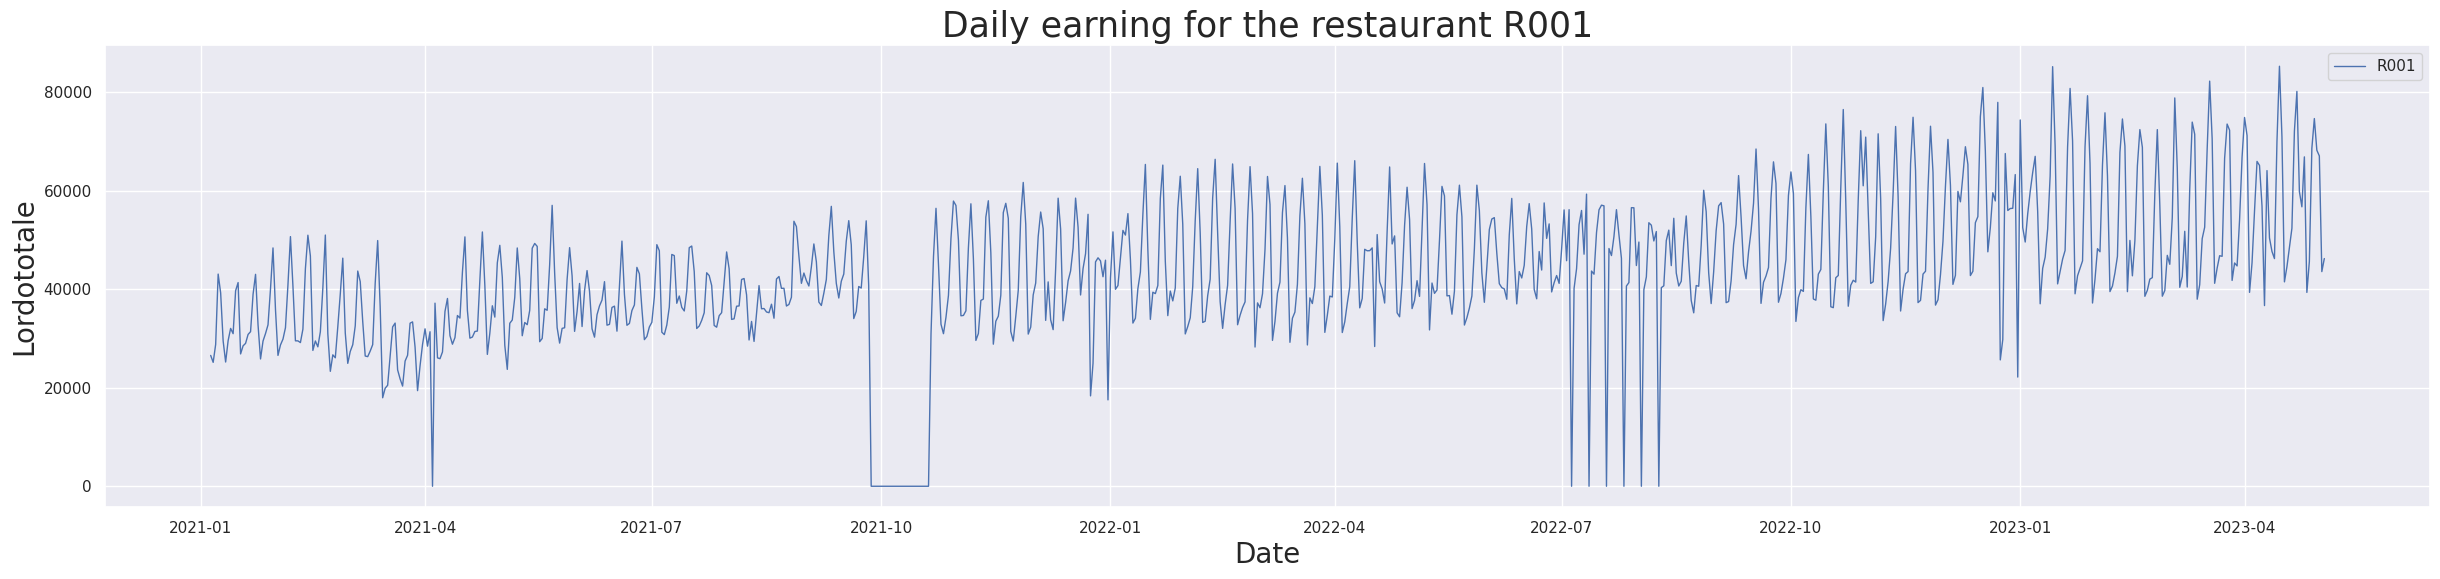

In [226]:
plot_rest(data_piacenza_1)

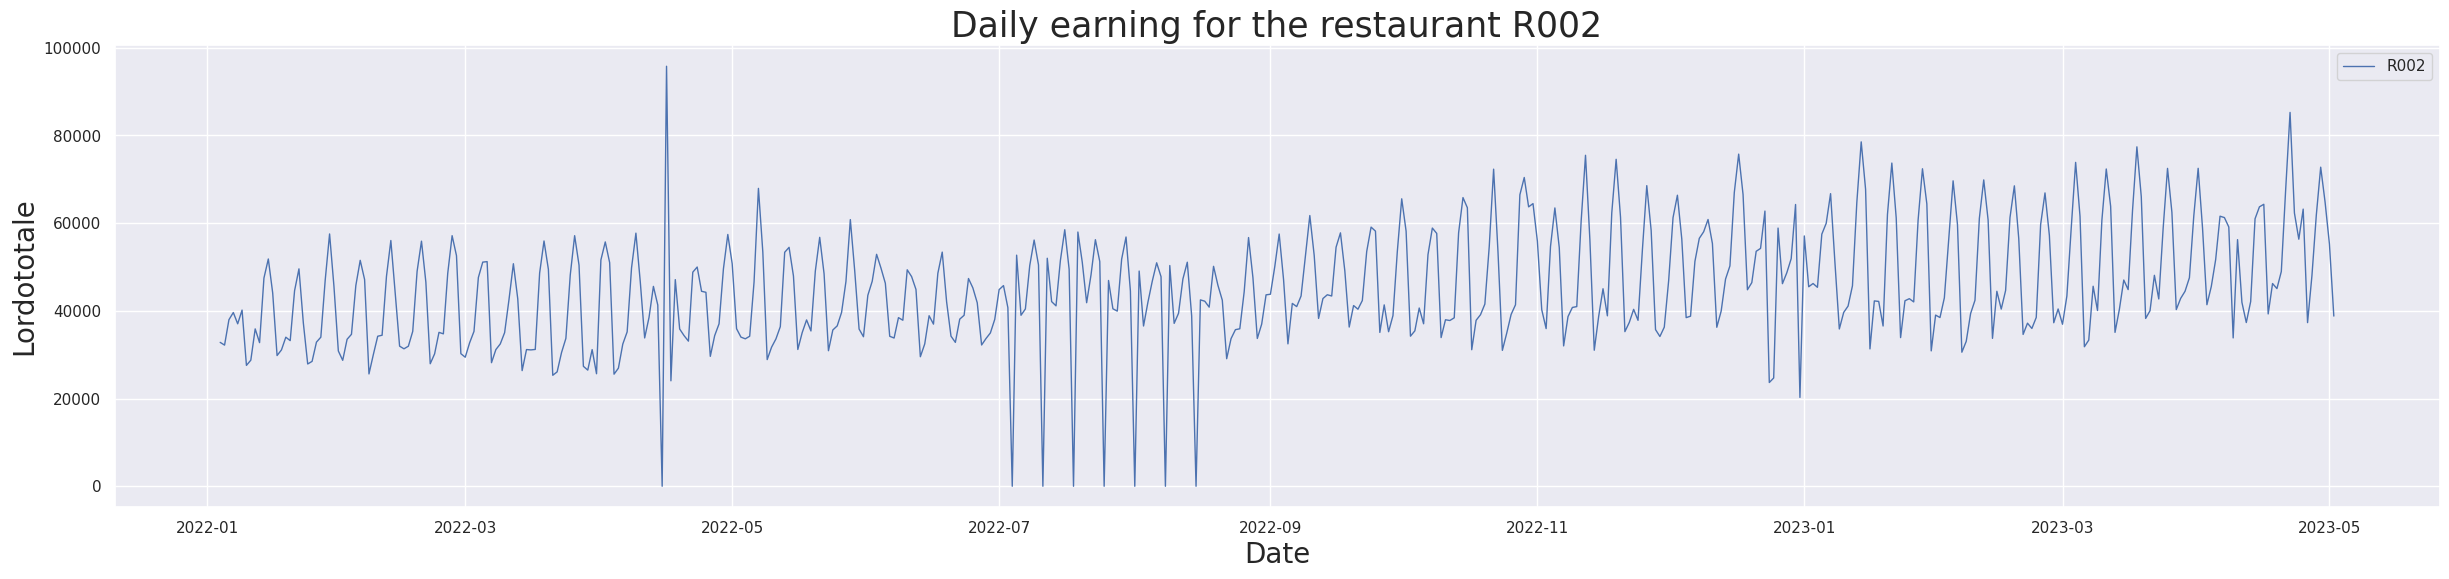

In [227]:
plot_rest(data_piacenza_2)

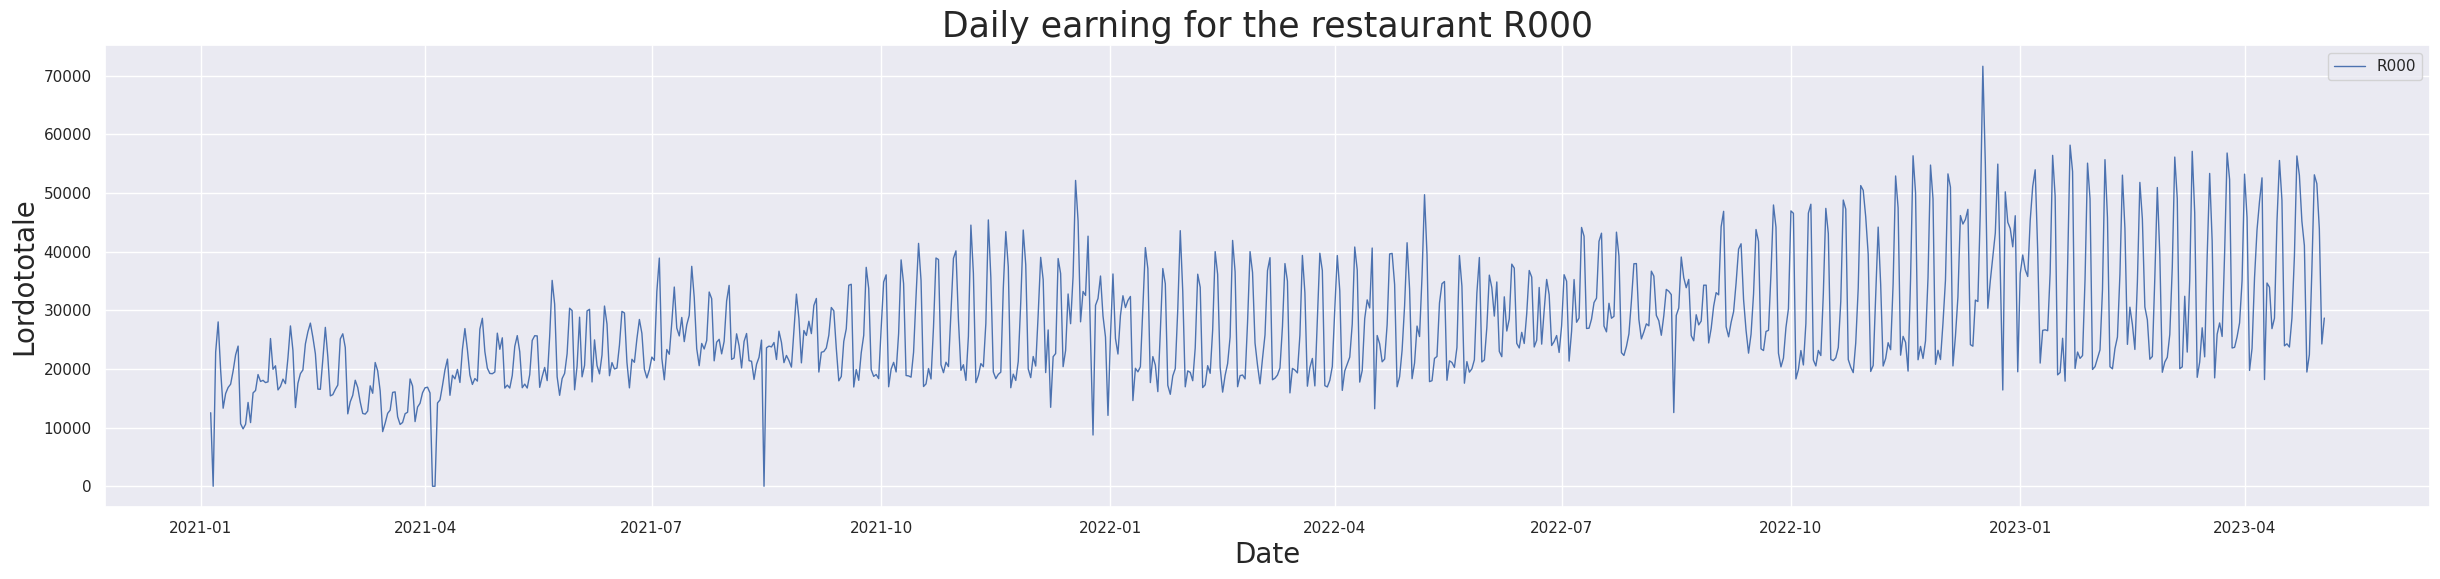

In [228]:
plot_rest(data_montebello)

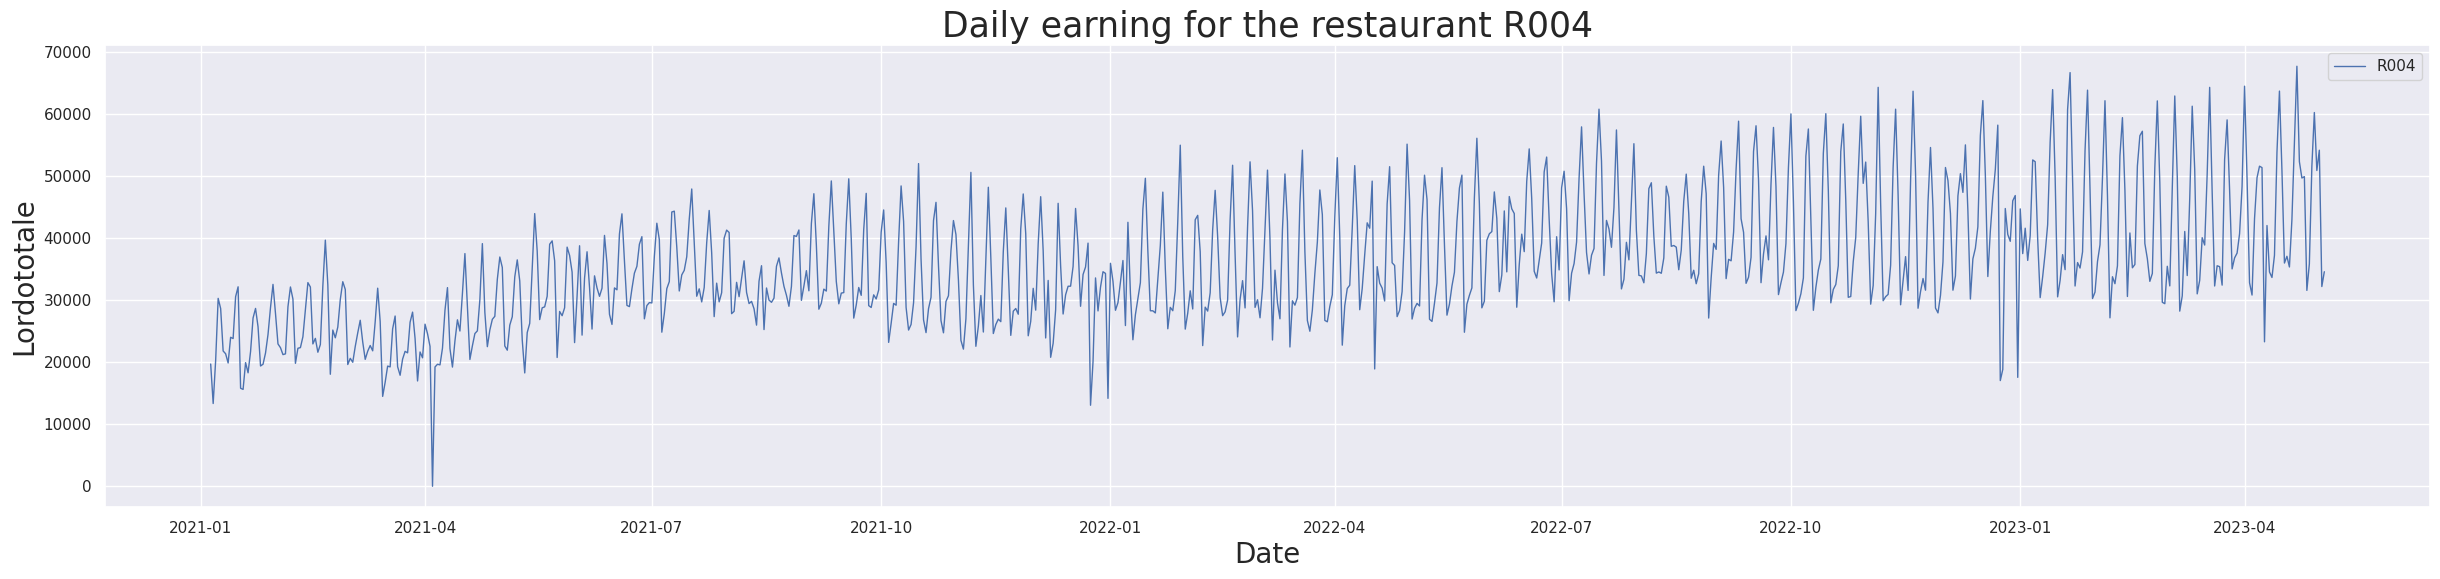

In [229]:
plot_rest(data_stradella)

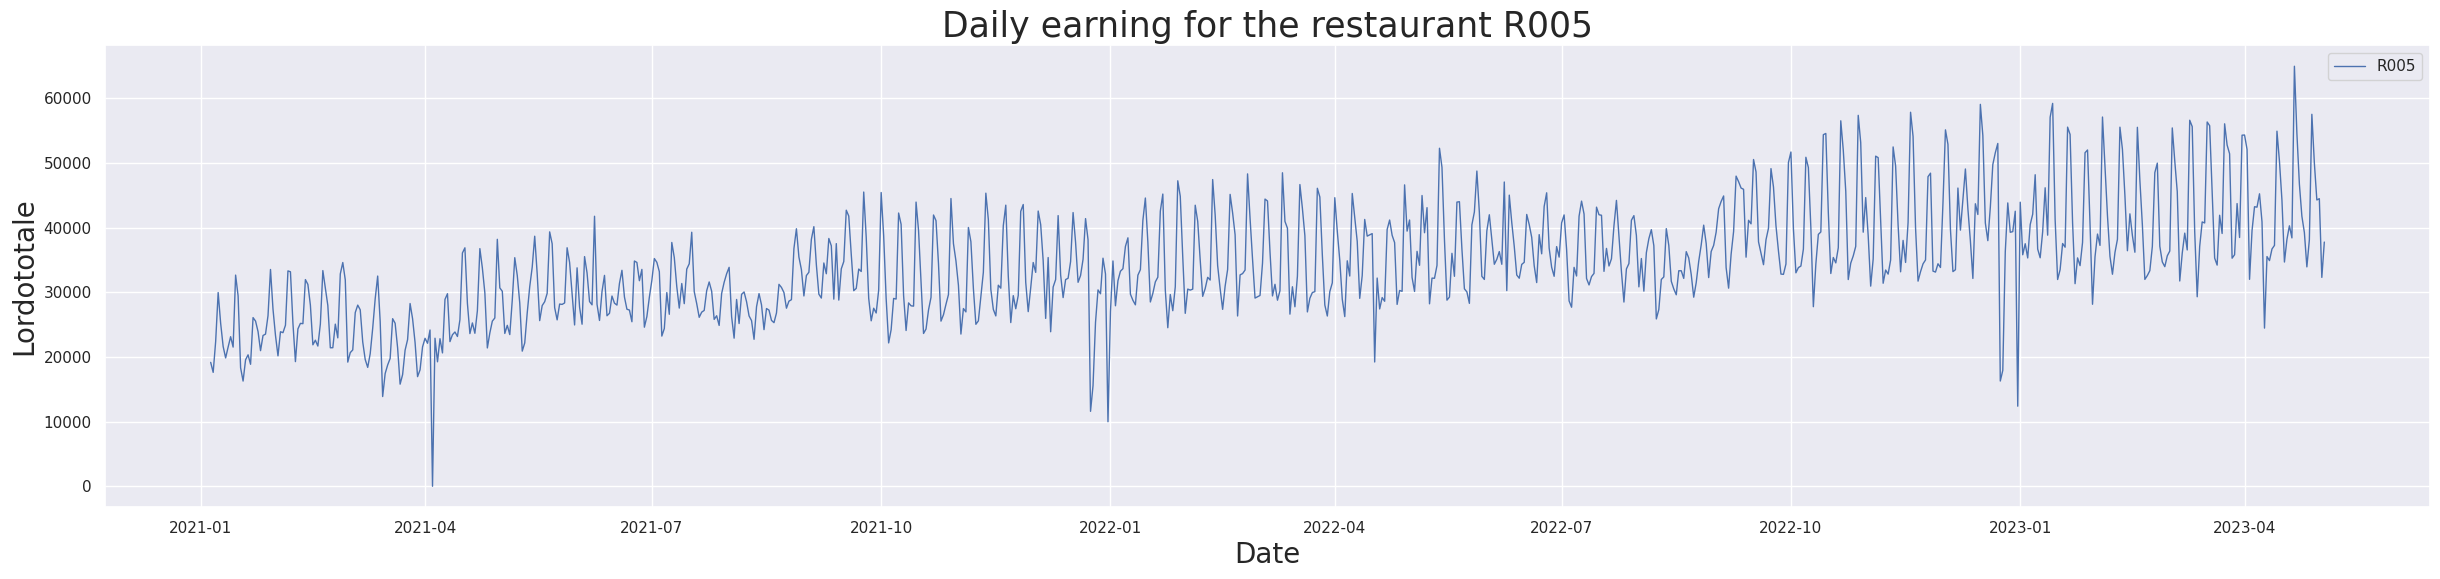

In [230]:
plot_rest(data_voghera)

# Modeling

Forecast for 1 future day and measure average percent of error for each restaurant separately

## Preparation of test and training data sets for sliding modeling

Functions for the spliting and forming future dataset

In [231]:
# 729 days, train size = 2 years
N = 729 

def train_test_split(data, days_num = N):
  train_end = days_num
  test_start = train_end - 1
  train_data = data[:train_end]
  test_data = data[test_start:]
  return train_data, test_data

# form future date + regressors for the forecast
def future_date(test_data):
  test_dates = test_data[['ds', 'FENOMENI', 'lag7']].reset_index(drop=True)
  return test_dates

Spliting train and test dataset for each restaurant

In [232]:
train_piacenza_1, test_piacenza_1 = train_test_split(data_piacenza_1)
train_piacenza_2, test_piacenza_2 = train_test_split(data_piacenza_2, days_num = 365)
train_montebello, test_montebello = train_test_split(data_montebello)
train_voghera, test_voghera = train_test_split(data_voghera)
train_stradella, test_stradella = train_test_split(data_stradella)

Dataset for the forecast which consist of future dates we want to get predictions for and values of regressors for this future dates

In [233]:
test_date_piacenza_1 = future_date(test_piacenza_1)
test_date_piacenza_2 = future_date(test_piacenza_2)
test_date_montebello = future_date(test_montebello)
test_date_voghera = future_date(test_voghera)
test_date_stradella = future_date(test_stradella)

In [234]:
train_piacenza_1.head()

ds           y ristorante  FENOMENI     place        lag1  \
0 2021-01-05  26544.6664       R001         9  Piacenza  37511.3032   
1 2021-01-06  25139.5578       R001         6  Piacenza  26544.6664   
2 2021-01-07  28784.6132       R001         1  Piacenza  25139.5578   
3 2021-01-08  43048.4355       R001         1  Piacenza  28784.6132   
4 2021-01-09  39224.4272       R001         1  Piacenza  43048.4355   

         lag7  
0  36599.6470  
1  37918.2321  
2   7785.6695  
3  23369.1920  
4  26548.7551

In [235]:
test_piacenza_1.head()

ds           y ristorante  FENOMENI     place        lag1  \
728 2023-01-03  49555.2505       R001         7  Piacenza  52468.8003   
729 2023-01-04  55274.1028       R001         1  Piacenza  49555.2505   
730 2023-01-05  59806.4887       R001         3  Piacenza  55274.1028   
731 2023-01-06  63659.9026       R001         1  Piacenza  59806.4887   
732 2023-01-07  66937.3880       R001         6  Piacenza  63659.9026   

           lag7  
728  55946.6733  
729  56354.4695  
730  56401.0559  
731  63238.9730  
732  22155.1785

In [236]:
test_date_piacenza_1.head()

ds  FENOMENI        lag7
0 2023-01-03         7  55946.6733
1 2023-01-04         1  56354.4695
2 2023-01-05         3  56401.0559
3 2023-01-06         1  63238.9730
4 2023-01-07         6  22155.1785

### Adding Holidays and Special Events into the model

**Treating COVID-19 lockdowns and Ramadan as a one-off holidays**

We have an entry for each lockdown period, with `ds` specifying the start of the lockdown. `ds_upper` is not used by Prophet, but it’s a convenient way for us to calculate upper_window.

**upper_window** tells Prophet that the lockdown spans for x days after the start of the lockdown. Note that the holidays regression is inclusive of the upper bound.




In [237]:
ramadan = pd.DataFrame([
    {'holiday': 'ramadan_2021', 'ds': '2021- 04-12', 'lower_window': 0, 'ds_upper': '2021-05-12'},
    {'holiday': 'ramadan_2022', 'ds': '2022-04-01', 'lower_window': 0, 'ds_upper': '2022-05-01'},
    {'holiday': 'ramadan_2023', 'ds': '2023-03-22', 'lower_window': 0, 'ds_upper': '2023-04-21'},
])
for t_col in ['ds', 'ds_upper']:
    ramadan[t_col] = pd.to_datetime(ramadan[t_col])
ramadan['upper_window'] = (ramadan['ds_upper'] - ramadan['ds']).dt.days

lockdowns = pd.DataFrame([
    # {'holiday': 'lockdown_1', 'ds': '2020-03-09', 'lower_window': 0, 'ds_upper': '2020-05-18'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-04', 'lower_window': 0, 'ds_upper': '2021-01-05'},
    {'holiday': 'lockdown_3_easter', 'ds': '2021-04-01', 'lower_window': 0, 'ds_upper': '2021-04-06'},
    {'holiday': 'something_we_dont_know', 'ds': '2021-09-27', 'lower_window': 0, 'ds_upper': '2021-10-20'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days


holiday_list = ['20201231',
                '20210101', '20210106', '20210216',
                '20210308', '20210319', '20210328', 
                '20210404', '20210405', '20210425',  
                '20210501', '20210509', '20210602', 
                '20210711',
                '20210815', '20210815', '20211208', 
                '20211224', '20211225', '20211226', 
                '20211231', '20220101', '20220106', 
                '20220301', '20220308', '20220319', 
                '20220410', '20220417', '20220418', 
                '20220425', '20220501', '20220508', 
                '20220602', '20220815', '20221101', 
                '20221208', '20221218', '20221224', 
                '20221225', 
                '20221226', '20221231', '20230101', 
                '20230106', '20230221', '20230308', 
                '20230319', '20230402', '20230409', 
                '20230410', '20230425', '20230501', 
                '20230514', 
                '20220705', '20220712', '20220719',  # don't know why this dates
                '20220802', '20220809']              # don't know why this dates

celebrations = pd.DataFrame({
  'holiday': 'holiday',
  'ds': pd.to_datetime(holiday_list),
  'lower_window': 0,
  'upper_window': 0,
})

holidays = pd.concat((celebrations, lockdowns, ramadan))

### Model and evaluation

Function for the result evaluation 

In [238]:
def evaluate_train_performance(real_data, pred_data):
    
    metrics_list = []

    # mean squared error (MSE)
    mse = round(mean_squared_error(real_data, pred_data), 2)

    # root mean squared error (RMSE)
    rmse = round(np.sqrt(mse), 2)

    # mean absolute error (MAE)
    mae = round(mean_absolute_error(real_data, pred_data), 2)

    # mean absolute percentage error (MAPE)
    mape = round(mean_absolute_percentage_error(real_data, pred_data) * 100, 2)

    metrics_list.append({'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape})
    
    return metrics_list

def print_metrics(metrics_list, rest_name):

    print(f"Test metrics for the {rest_name}\n")

    for metrics in metrics_list:
        print(f'Mean Squared Error (MSE): {metrics["mse"]}')
        print(f'Root Mean Squared Error (RMSE): {metrics["rmse"]}')
        print(f'Mean Absolute Error (MAE): {metrics["mae"]}')
        print(f'Mean Absolute Percentage Error (MAPE): {metrics["mape"]}')


Function for making prediction

In [239]:
def prophet_pred(train_data, test_data, test_dates, holidays = holidays, train_end = N):
    
    predictions = pd.DataFrame()

    for i in range(len(test_data)-1):
        print('iteration = ', i)
        
        # get the rolling train set
        train_set = train_data[:train_end+i]

        # fit the Prophet model
        model = Prophet(holidays=holidays, 
                    weekly_seasonality = True, 
                    daily_seasonality = False,
                    )
        model.add_country_holidays(country_name='IT')
        model.add_regressor('FENOMENI')
        # model.add_regressor('lag1')
        model.add_regressor('lag7')

        model_fit = model.fit(train_set)

        # forecast the next value
        forecast = model_fit.predict(pd.DataFrame(test_dates.loc[[i+1]]))

        # append the predicted value to the dataframe
        print(forecast[['ds', 'yhat']])
        predictions = predictions.append(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], ignore_index=True)

        # update the train set
        train_data = train_data.append(test_data.iloc[i])


    # store results and evaluate
    results = pd.merge(test_data, predictions, on='ds')
    metrics = evaluate_train_performance(results.y, results.yhat)
    
    return results, metrics, model_fit


In [ ]:
pred_piacenza_1, metrics_p1, model_p1 = prophet_pred(train_piacenza_1, test_piacenza_1, test_date_piacenza_1)

In [ ]:
pred_montebello, metrics_m, model_m = prophet_pred(train_montebello, test_montebello, test_date_montebello)

In [ ]:
pred_voghera, metrics_v, model_v = prophet_pred(train_voghera, test_voghera, test_date_voghera)


In [ ]:
pred_stradella, metrics_s, model_s = prophet_pred(train_stradella, test_stradella, test_date_stradella)


In [ ]:
pred_piacenza_2, metrics_p2, model_p2 = prophet_pred(train_piacenza_2, test_piacenza_2, test_date_piacenza_2, train_end = 365)


In [245]:
# save models

with open('/content/gdrive/MyDrive/DSLab_project/model_p1.json', 'w') as fout:
    fout.write(model_to_json(model_p1)) 

with open('/content/gdrive/MyDrive/DSLab_project/model_p2.json', 'w') as fout:
    fout.write(model_to_json(model_p2)) 

with open('/content/gdrive/MyDrive/DSLab_project/model_m.json', 'w') as fout:
    fout.write(model_to_json(model_m)) 

with open('/content/gdrive/MyDrive/DSLab_project/model_v.json', 'w') as fout:
    fout.write(model_to_json(model_v)) 

with open('/content/gdrive/MyDrive/DSLab_project/model_s.json', 'w') as fout:
    fout.write(model_to_json(model_s)) 



In [ ]:
# # load model

# with open('/content/gdrive/MyDrive/DSLab_project/model_p1.json', 'r') as fin:
#     model_p1 = model_from_json(fin.read()) 

# with open('/content/gdrive/MyDrive/DSLab_project/model_p2.json', 'r') as fin:
#     model_p2 = model_from_json(fin.read()) 

# with open('/content/gdrive/MyDrive/DSLab_project/model_m.json', 'r') as fin:
#     model_m = model_from_json(fin.read()) 

# with open('/content/gdrive/MyDrive/DSLab_project/model_v.json', 'r') as fin:
#     model_v = model_from_json(fin.read()) 

# with open('/content/gdrive/MyDrive/DSLab_project/model_s.json', 'r') as fin:
#     model_s = model_from_json(fin.read()) 



In [246]:
# save predicted values into folder

file_path1 = '/content/gdrive/MyDrive/DSLab_project/pred_piacenza_1.csv'
file_path2 = '/content/gdrive/MyDrive/DSLab_project/pred_piacenza_2.csv'
file_path3 = '/content/gdrive/MyDrive/DSLab_project/pred_montebello.csv'
file_path4 = '/content/gdrive/MyDrive/DSLab_project/pred_voghera.csv'
file_path5 = '/content/gdrive/MyDrive/DSLab_project/pred_stradella.csv'

pred_piacenza_1.to_csv(file_path1, index=False)
pred_piacenza_2.to_csv(file_path2, index=False)
pred_montebello.to_csv(file_path3, index=False)
pred_voghera.to_csv(file_path4, index=False)
pred_stradella.to_csv(file_path5, index=False)

In [ ]:
# # upload saved predicted values

# pred_piacenza_1 = pd.read_csv("/content/gdrive/MyDrive/DSLab_project/pred_piacenza_1.csv")
# pred_piacenza_2 = pd.read_csv("/content/gdrive/MyDrive/DSLab_project/pred_piacenza_2.csv")
# pred_montebello = pd.read_csv("/content/gdrive/MyDrive/DSLab_project/pred_montebello.csv")
# pred_voghera = pd.read_csv("/content/gdrive/MyDrive/DSLab_project/pred_voghera.csv")
# pred_stradella = pd.read_csv("/content/gdrive/MyDrive/DSLab_project/pred_stradella.csv")


In [247]:
print_metrics(metrics_p1, 'R001 Piacenza')

Test metrics for the R001 Piacenza

Mean Squared Error (MSE): 61267054.57
Root Mean Squared Error (RMSE): 7827.33
Mean Absolute Error (MAE): 5951.6
Mean Absolute Percentage Error (MAPE): 10.77


In [248]:
print_metrics(metrics_m, 'R000 Montebello')

Test metrics for the R000 Montebello

Mean Squared Error (MSE): 48275792.27
Root Mean Squared Error (RMSE): 6948.08
Mean Absolute Error (MAE): 5588.25
Mean Absolute Percentage Error (MAPE): 17.74


In [249]:
print_metrics(metrics_v, 'R005 Voghera')

Test metrics for the R005 Voghera

Mean Squared Error (MSE): 23008942.32
Root Mean Squared Error (RMSE): 4796.76
Mean Absolute Error (MAE): 3790.43
Mean Absolute Percentage Error (MAPE): 9.05


In [250]:
print_metrics(metrics_s, 'R004 Stradella')

Test metrics for the R004 Stradella

Mean Squared Error (MSE): 28974860.83
Root Mean Squared Error (RMSE): 5382.83
Mean Absolute Error (MAE): 4222.37
Mean Absolute Percentage Error (MAPE): 10.12


In [251]:
print_metrics(metrics_p2, 'R002 Piacenza')

Test metrics for the R002 Piacenza

Mean Squared Error (MSE): 42690611.65
Root Mean Squared Error (RMSE): 6533.81
Mean Absolute Error (MAE): 4543.37
Mean Absolute Percentage Error (MAPE): 9.41


### Plot of the prediction and real values in test set

In [252]:
def plot_pred(pred_data, rest_name):

    sns.set_style('darkgrid')
    sns.set(rc={'figure.figsize':(30,7)})

    ax = sns.lineplot(data=pred_data, x ='ds', y = 'y', color='blue', label='Actual', lw=1)
    ax = sns.lineplot(data=pred_data, x ='ds', y = 'yhat', color = 'red', label= 'Forecast', lw=1)
    ax.scatter(data=pred_data, x='ds', y='y', label='Actual', color='blue')
    plt.fill_between(pred_data['ds'], pred_data['yhat_lower'], pred_data['yhat_upper'], alpha=0.3, color='orange')
    plt.title(f'Comparison of real and predicted values for the restaurant {rest_name}', fontsize=25)
    plt.ylabel('Lordototale', fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.show()

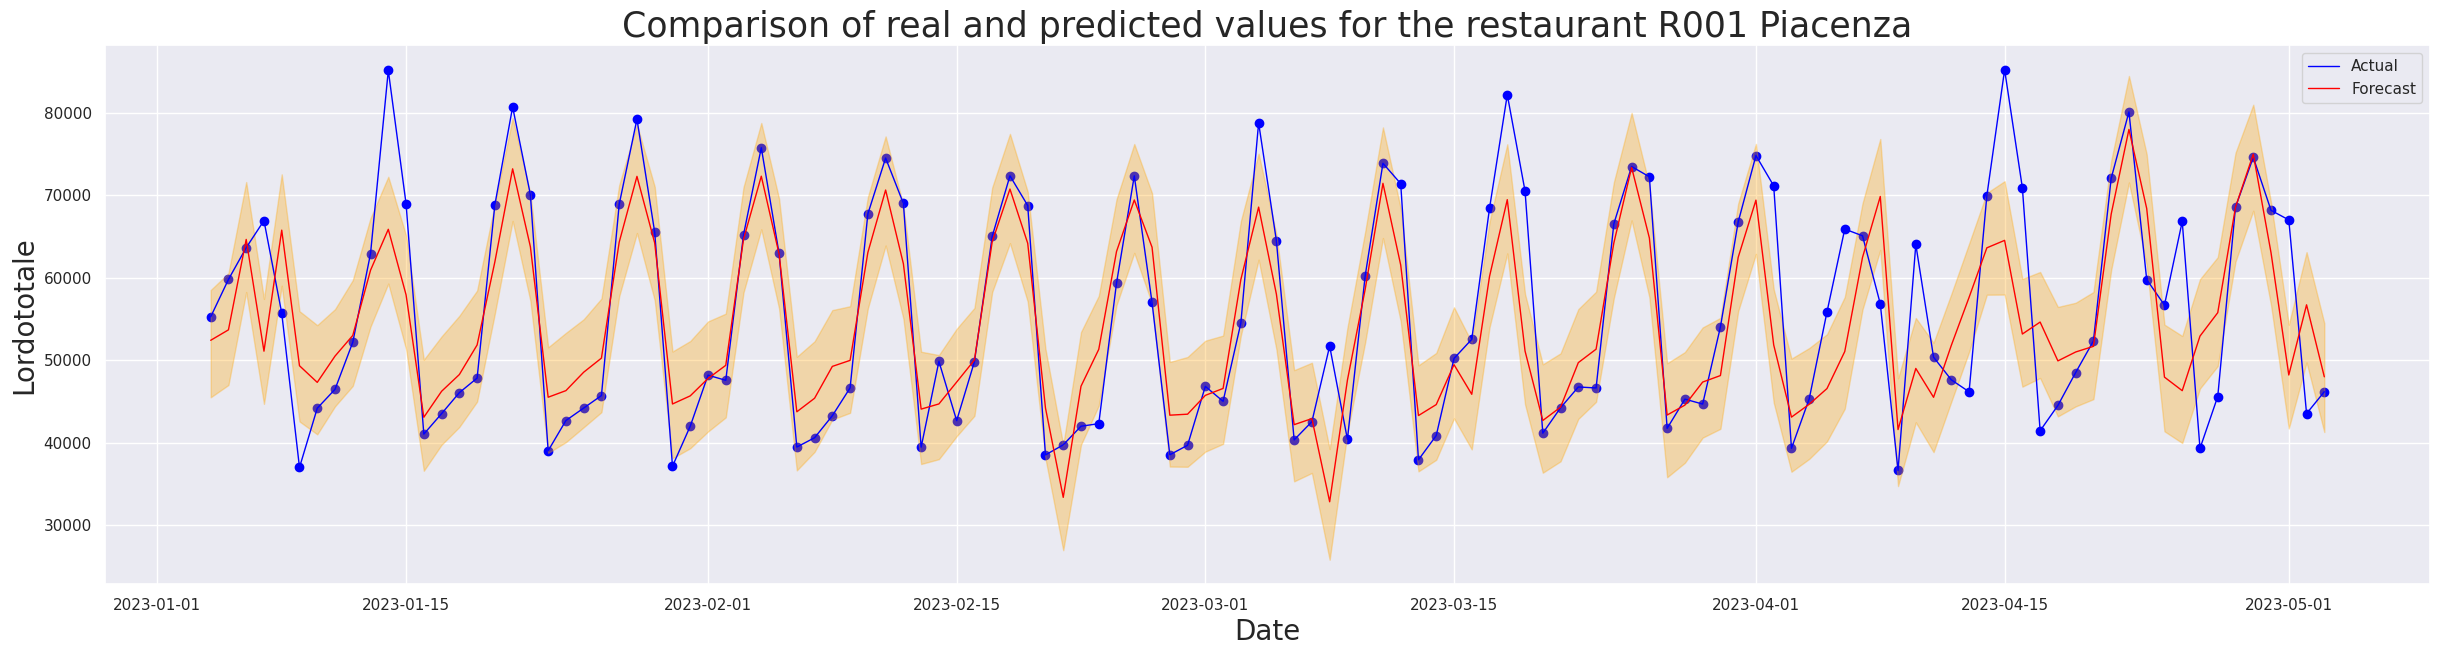

In [253]:
plot_pred(pred_piacenza_1, 'R001 Piacenza')

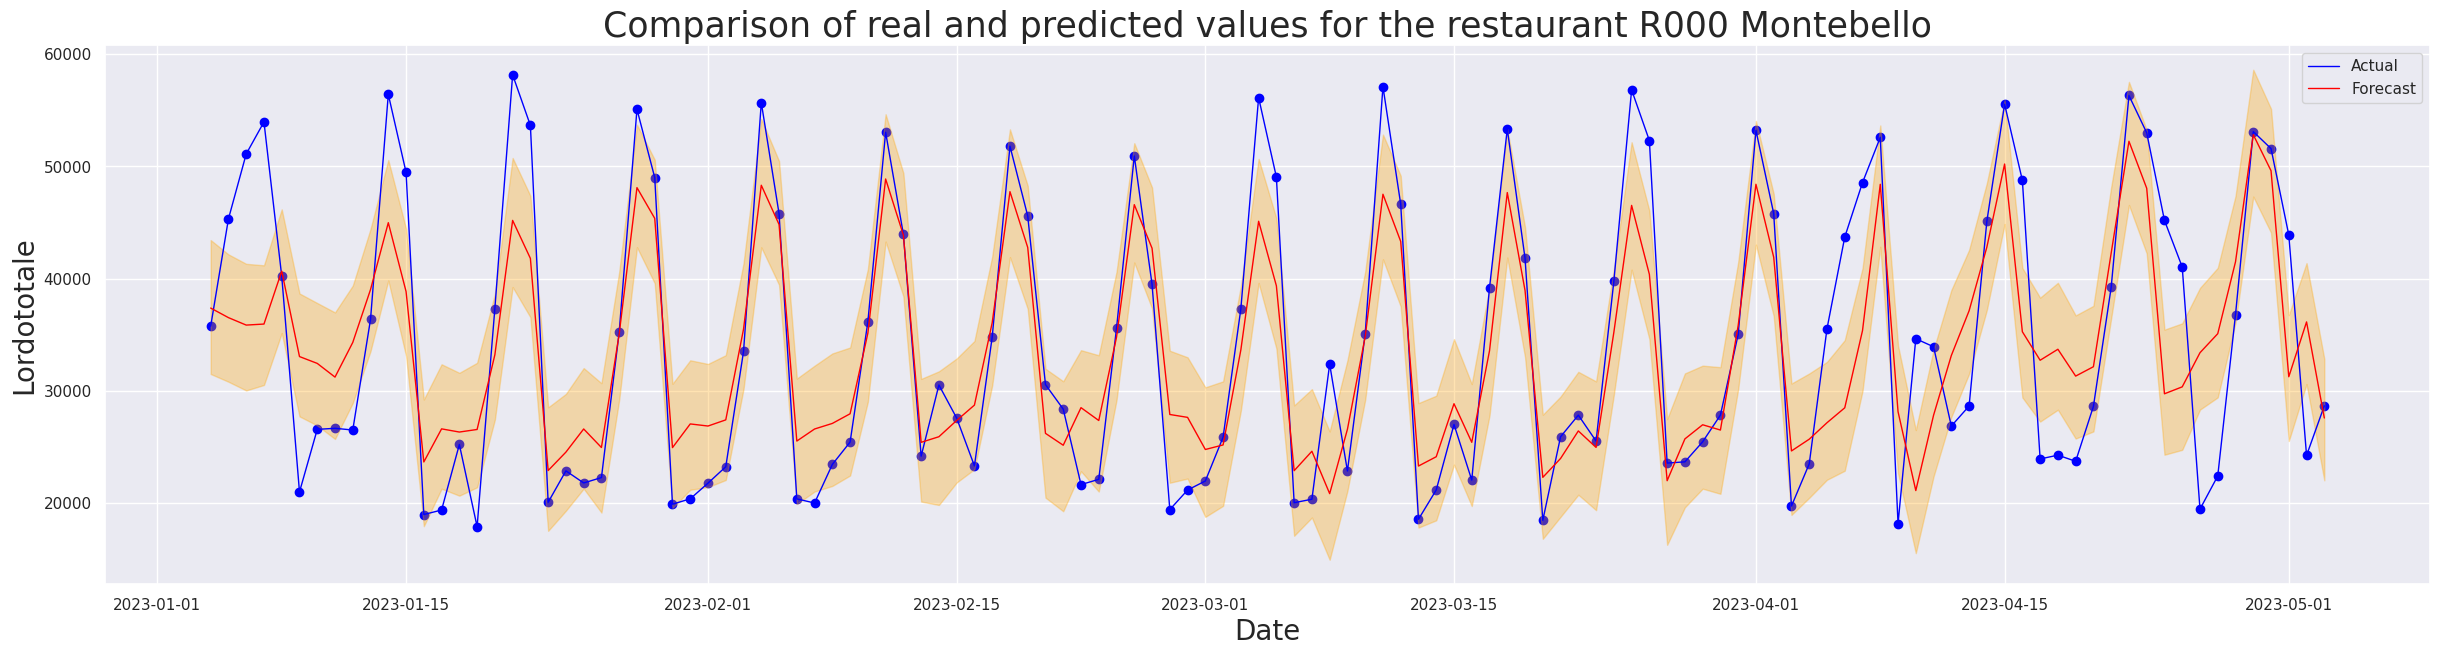

In [254]:
plot_pred(pred_montebello, 'R000 Montebello')

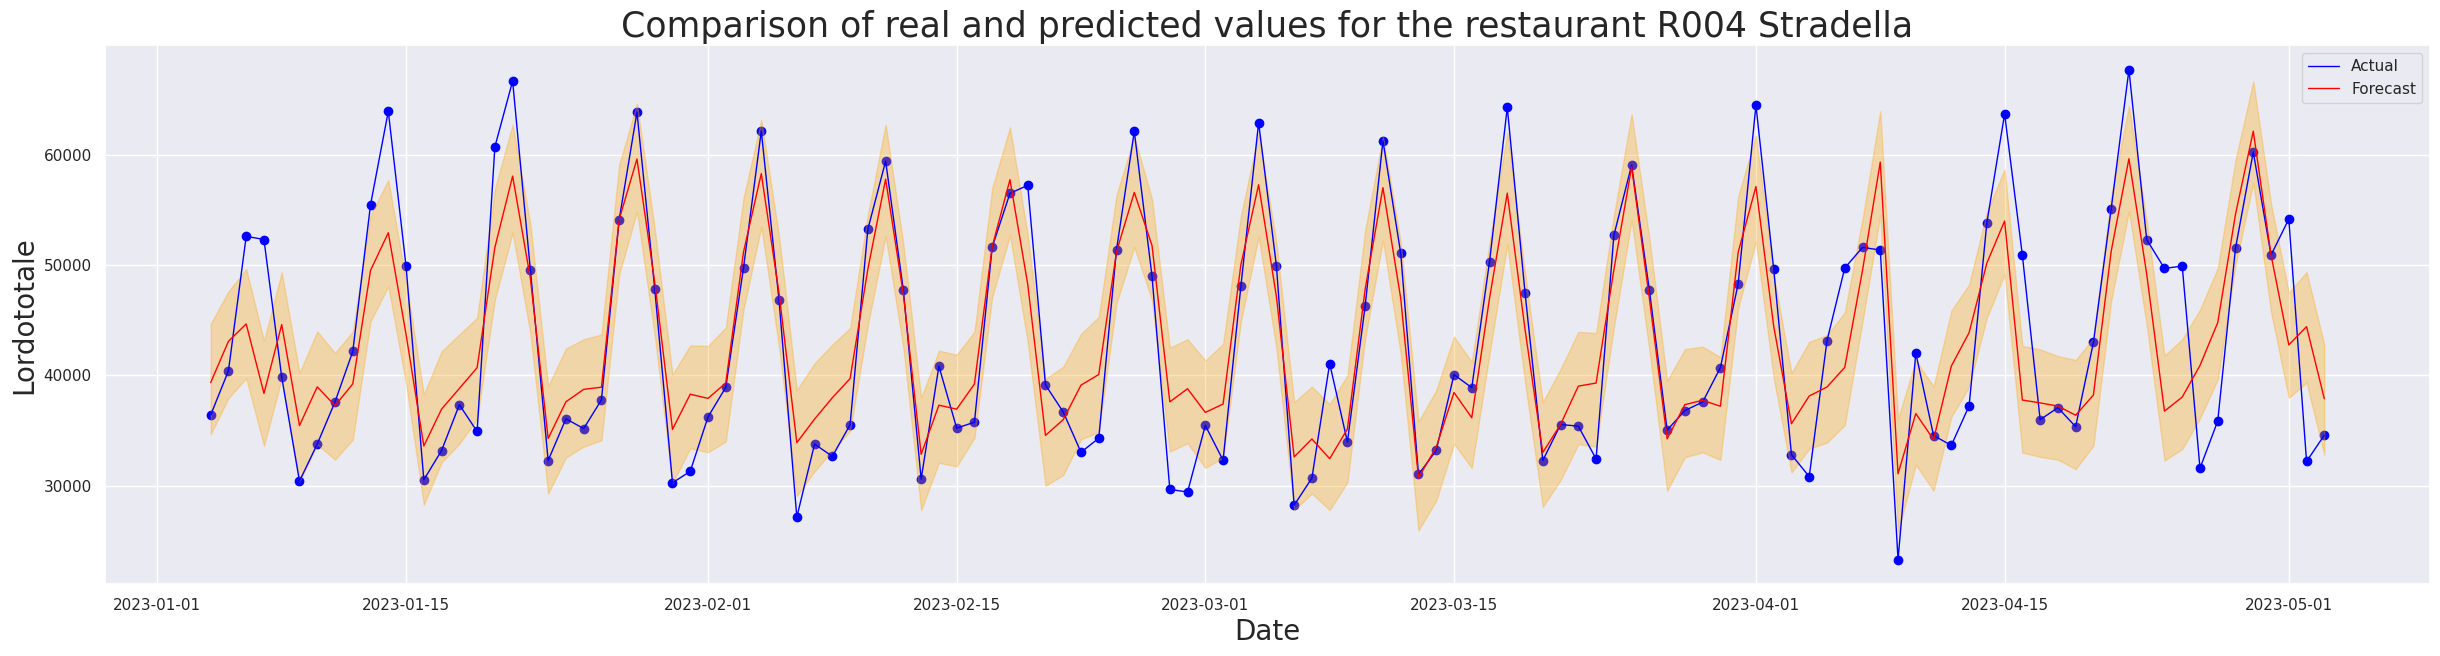

In [255]:
plot_pred(pred_stradella, 'R004 Stradella')

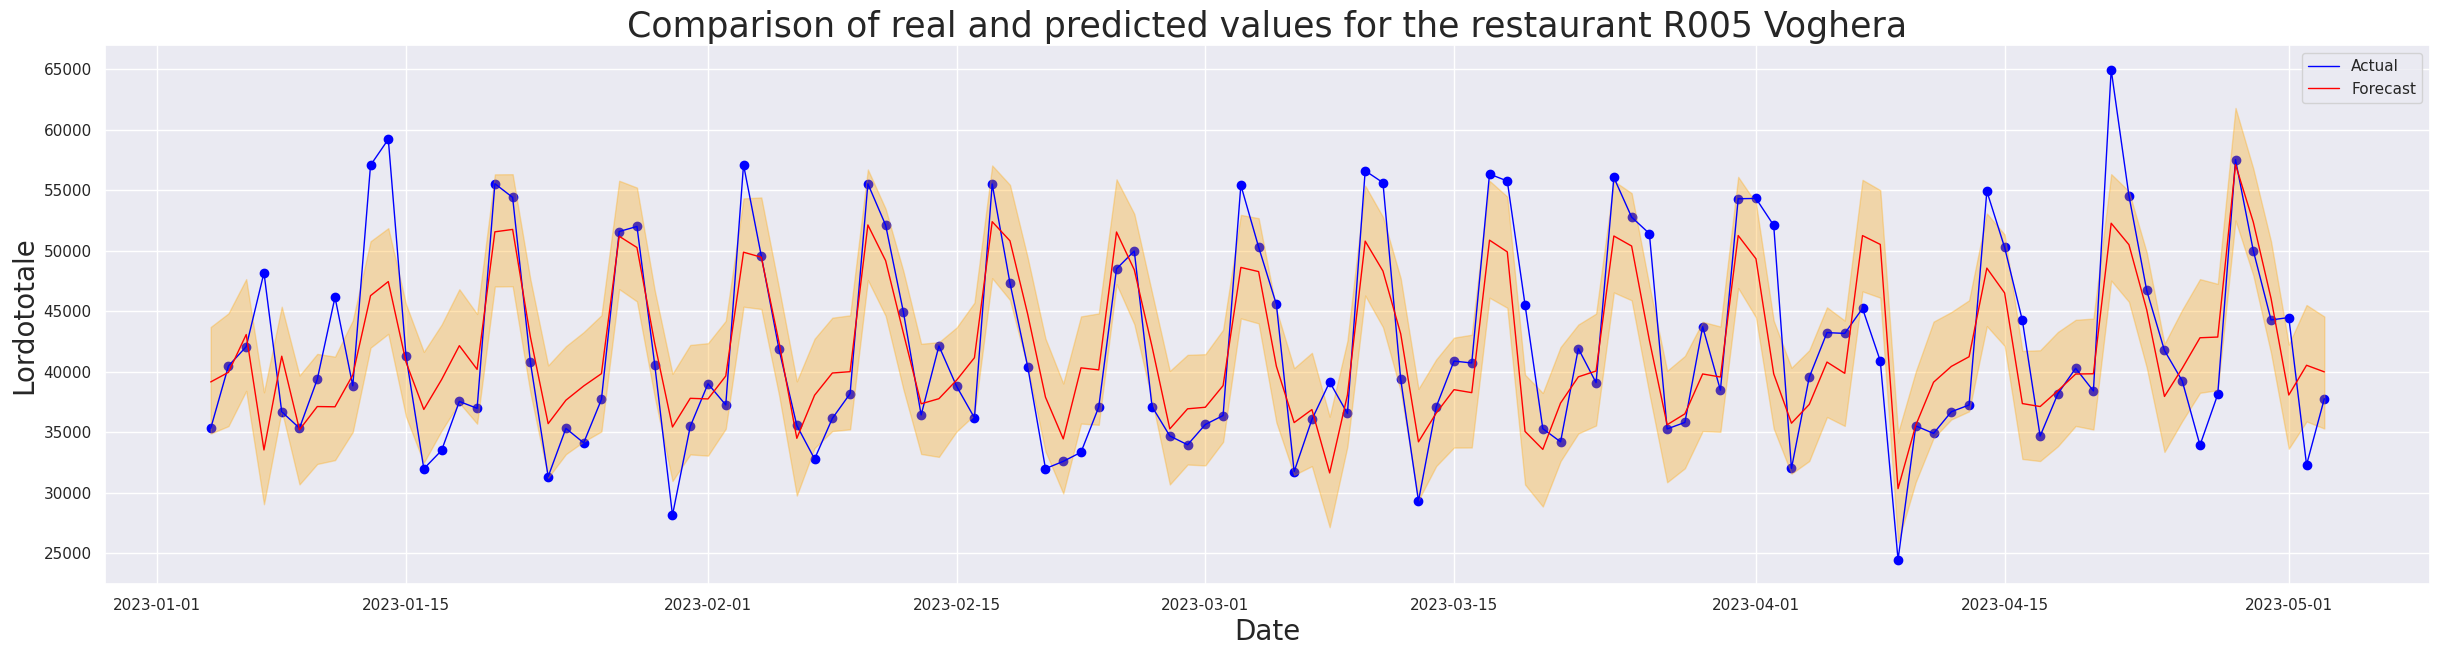

In [256]:
plot_pred(pred_voghera, 'R005 Voghera')

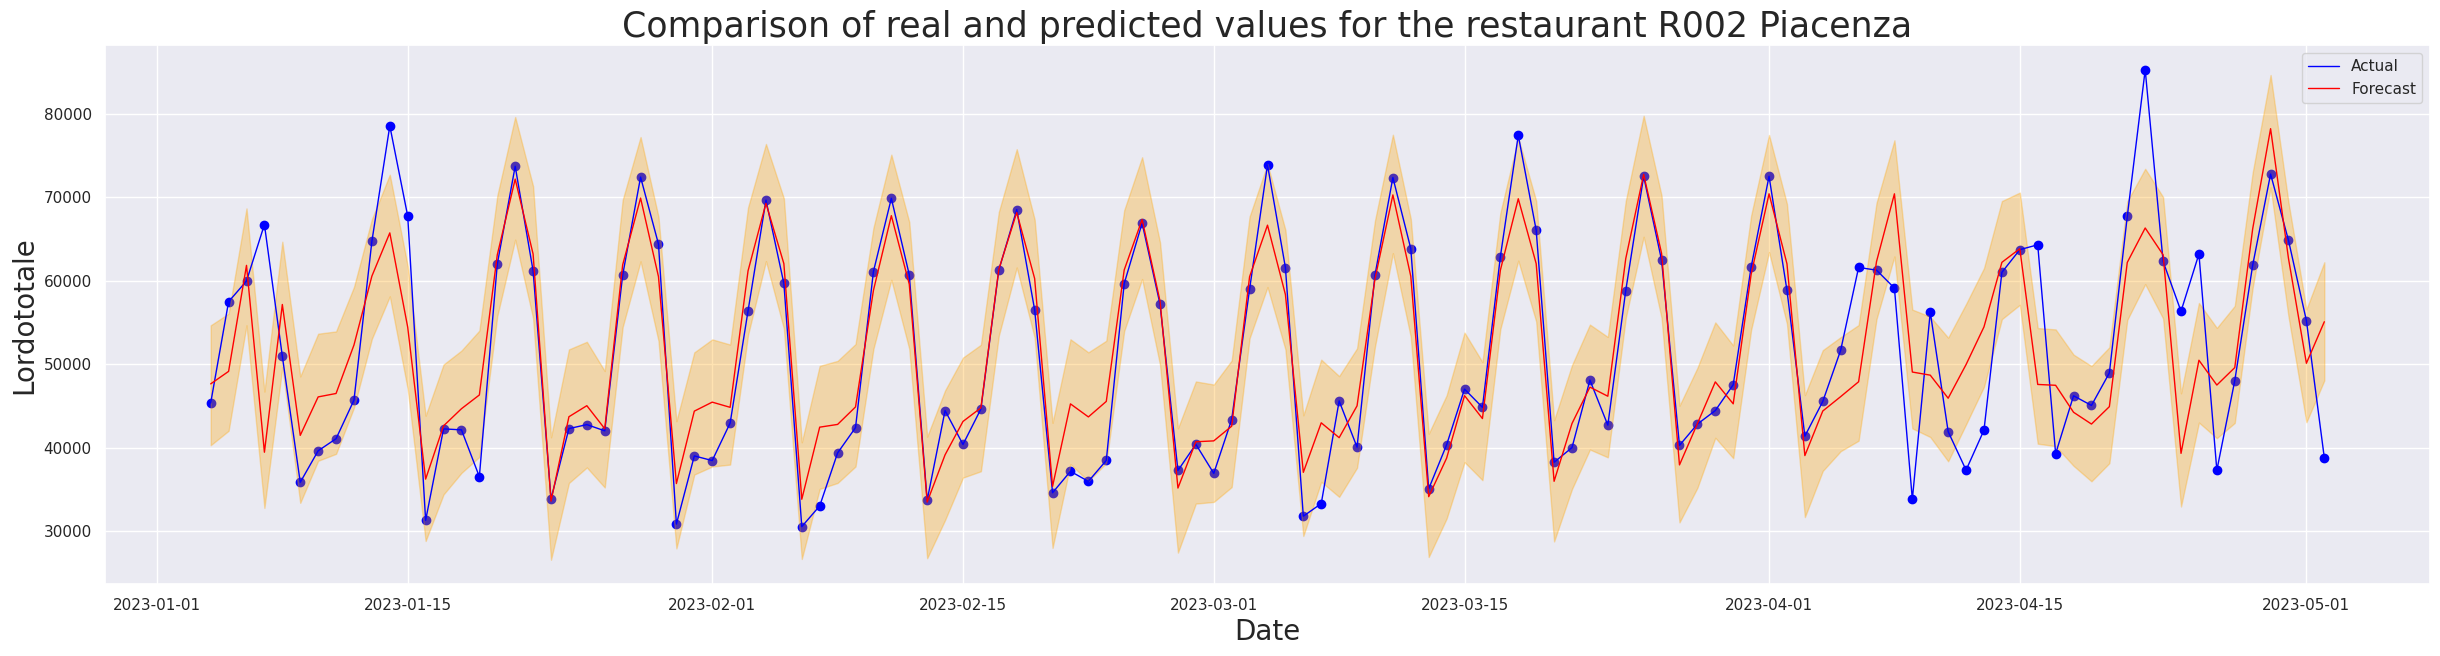

In [257]:
plot_pred(pred_piacenza_2, 'R002 Piacenza')

## Build prediction for 7 future days for each restaurant

In [258]:
# creating new dates for prediction

def creat_future_dates(num_days):
    start_date = pd.to_datetime('2023-05-04', format='%Y-%m-%d')
    end_date = pd.to_datetime('2023-05-04', format='%Y-%m-%d') + timedelta(days=num_days-1)

    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    fenomeni_values = 1

    df = pd.DataFrame({'ds': dates, 'FENOMENI': fenomeni_values})

    
    return df



In [259]:
future_dates = creat_future_dates(7)

In [260]:
def add_lag(data_of_rest, future_dates):
  data = data_of_rest.tail(7)
  data = data[['ds', 'y']]
  df = pd.concat((data, future_dates))
  df["lag7"] = df["y"].shift(7)
  df = df.tail(-7).reset_index(drop=True)
  df.drop('y', axis = 1, inplace=True)
  return df


In [261]:
dates_p1 = add_lag(data_piacenza_1, future_dates)
dates_p2 = add_lag(data_piacenza_2, future_dates)
dates_m = add_lag(data_montebello, future_dates)
dates_v = add_lag(data_voghera, future_dates)
dates_s = add_lag(data_stradella, future_dates)

In [262]:
dates_m

ds  FENOMENI        lag7
0 2023-05-04       1.0  22431.8059
1 2023-05-05       1.0  36796.7306
2 2023-05-06       1.0  53106.1006
3 2023-05-07       1.0  51591.7948
4 2023-05-08       1.0  43892.8140
5 2023-05-09       1.0  24259.6613
6 2023-05-10       1.0  28680.5372

In [263]:
forecast_p1 = model_p1.predict(dates_p1)
forecast_p2 = model_p2.predict(dates_p2)
forecast_m = model_m.predict(dates_m)
forecast_v = model_v.predict(dates_v)
forecast_s = model_s.predict(dates_s)


In [264]:
forecast_p1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds          yhat    yhat_lower    yhat_upper
0 2023-05-04  51430.712582  45185.561737  57954.854497
1 2023-05-05  67139.502249  60366.664593  73692.079825
2 2023-05-06  73640.604243  66802.057590  80422.582063
3 2023-05-07  66738.166064  59631.695952  73106.449259
4 2023-05-08  56713.757819  50454.596964  63433.624386
5 2023-05-09  47760.884280  41702.880074  54312.960825
6 2023-05-10  50692.499372  43735.952022  57531.054892

In [265]:
forecast_p2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds          yhat    yhat_lower    yhat_upper
0 2023-05-04  43514.481684  36195.821728  50910.301066
1 2023-05-05  56272.214805  49331.648495  63730.527755
2 2023-05-06  66234.072924  59124.346739  73430.059402
3 2023-05-07  67935.357192  59984.065609  75239.177839
4 2023-05-08  52578.619163  45784.653114  59753.776257
5 2023-05-09  51630.038116  44451.399964  58620.591398
6 2023-05-10  44200.472806  37377.646385  51485.742630

In [266]:
forecast_m[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds          yhat    yhat_lower    yhat_upper
0 2023-05-04  28915.590147  23243.072425  34166.808765
1 2023-05-05  38066.612054  32412.766835  43670.901625
2 2023-05-06  50085.575431  44601.069468  55778.989463
3 2023-05-07  47739.820209  42441.270325  53549.024198
4 2023-05-08  35333.263776  29454.702867  41209.576298
5 2023-05-09  27983.970346  22675.709212  34020.975432
6 2023-05-10  29711.557022  24295.889355  35167.083540

In [267]:
forecast_v[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds          yhat    yhat_lower    yhat_upper
0 2023-05-04  42156.887198  37501.054381  46476.597240
1 2023-05-05  54740.375211  50026.816643  59367.893926
2 2023-05-06  51660.348029  47516.439486  56362.447382
3 2023-05-07  45985.473626  41524.787833  50579.720422
4 2023-05-08  42038.693935  37693.310321  46654.323391
5 2023-05-09  39156.483280  34447.551256  43897.317607
6 2023-05-10  41634.464679  37112.565773  46556.746624

In [268]:
forecast_s[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds          yhat    yhat_lower    yhat_upper
0 2023-05-04  40216.751542  35398.127263  45289.075725
1 2023-05-05  52457.718611  47863.816207  57246.598549
2 2023-05-06  59648.363082  54664.323526  64467.440549
3 2023-05-07  51134.058208  45986.504598  55921.905222
4 2023-05-08  45374.573553  40457.429387  50174.486002
5 2023-05-09  38187.700746  33131.792400  42886.009231
6 2023-05-10  39516.821623  34605.027353  44224.306431

In [269]:
def plot_future(future_data, rest_name):

    sns.set_style('darkgrid')
    # sns.set(rc={'figure.figsize':(15,5)})

    ax = sns.lineplot(data=future_data, x ='ds', y = 'yhat', color = 'red', label= 'Forecast', lw=1)
    plt.fill_between(future_data['ds'], future_data['yhat_lower'], future_data['yhat_upper'], alpha=0.3, color='orange')
    ax.scatter(data=future_data, x='ds', y='yhat', color='red')
    plt.title(f'New 7 days forecast for the restaurant {rest_name}', fontsize=15)
    plt.ylabel('Lordototale', fontsize=10)
    plt.xlabel('Date', fontsize=10)
    plt.show()

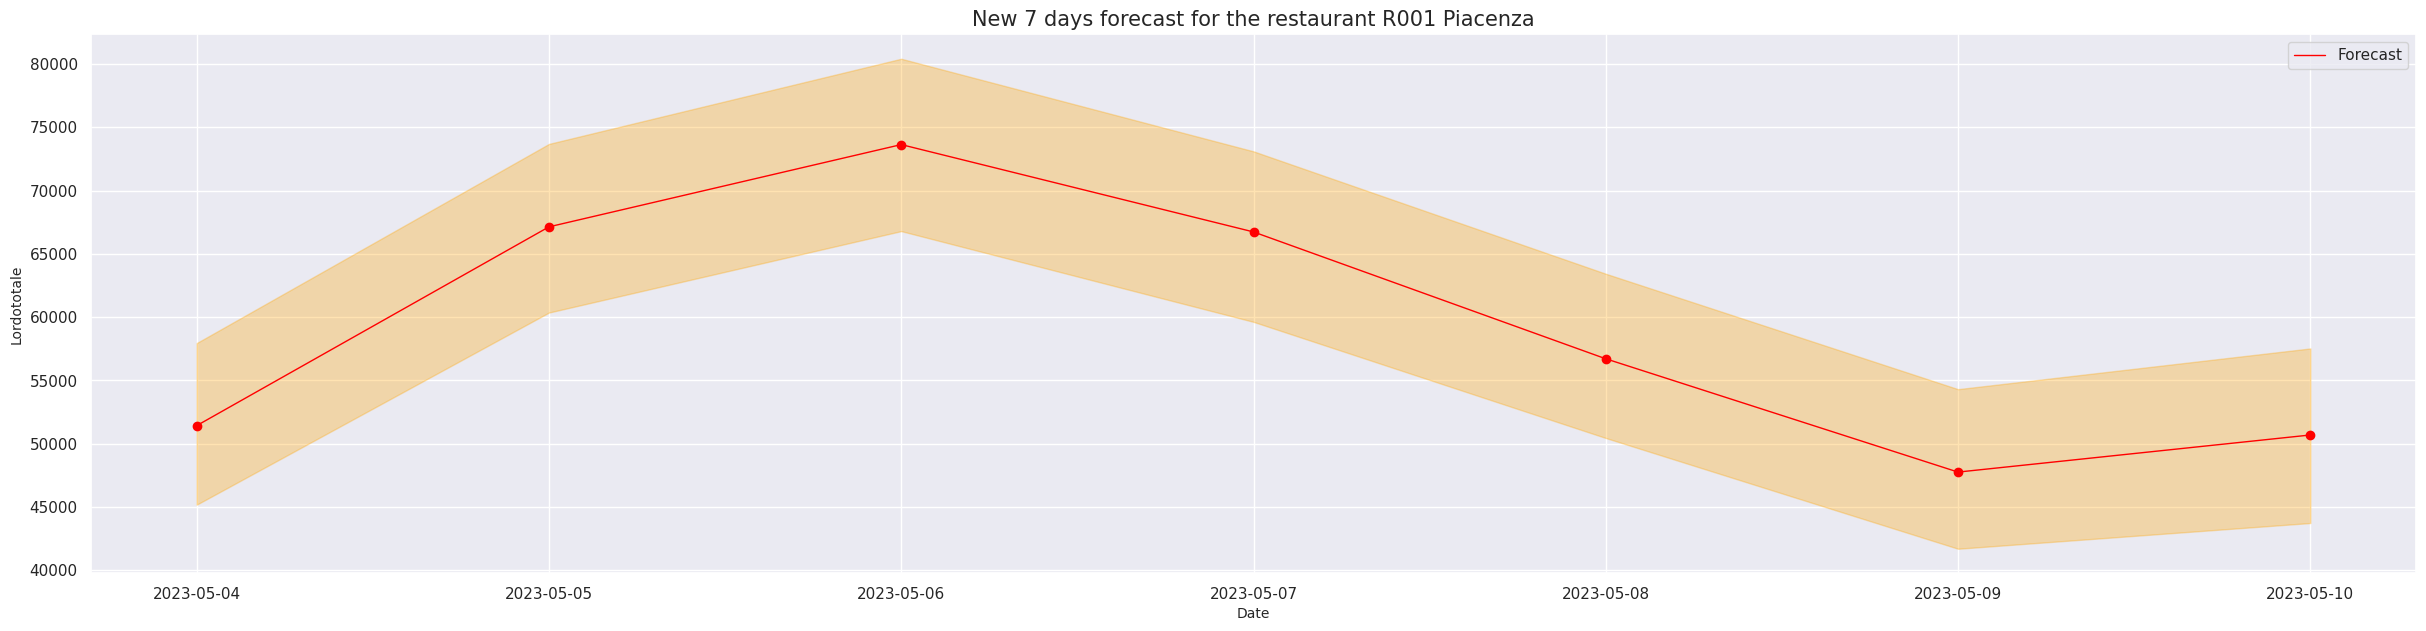

In [270]:
plot_future(forecast_p1, 'R001 Piacenza')

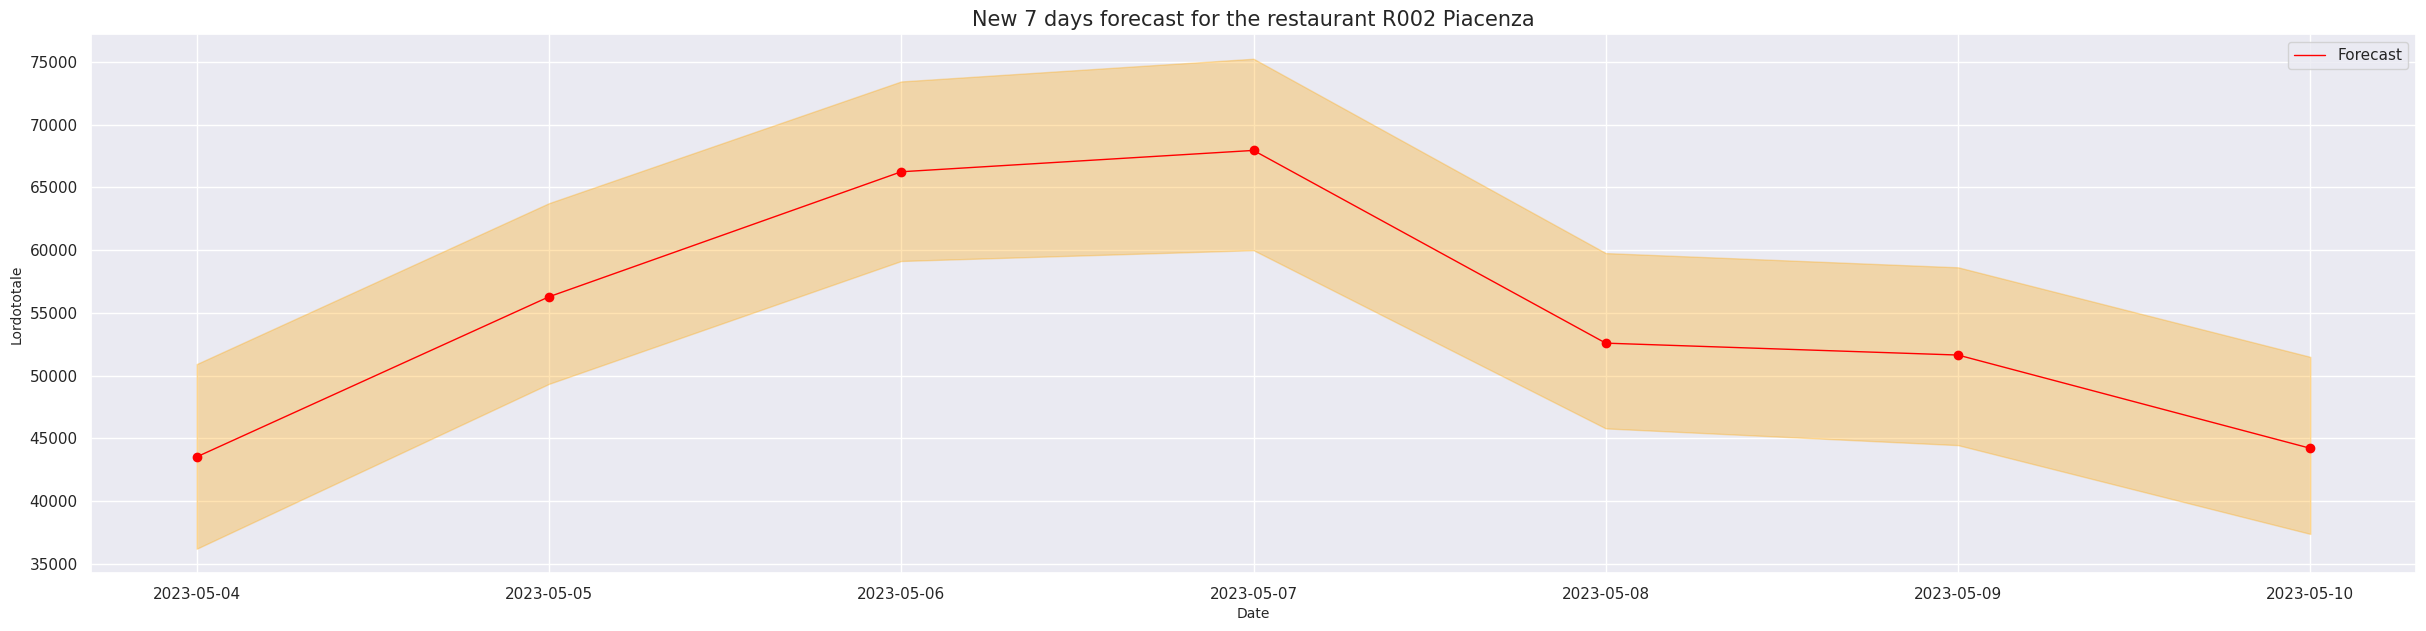

In [271]:
plot_future(forecast_p2, 'R002 Piacenza')

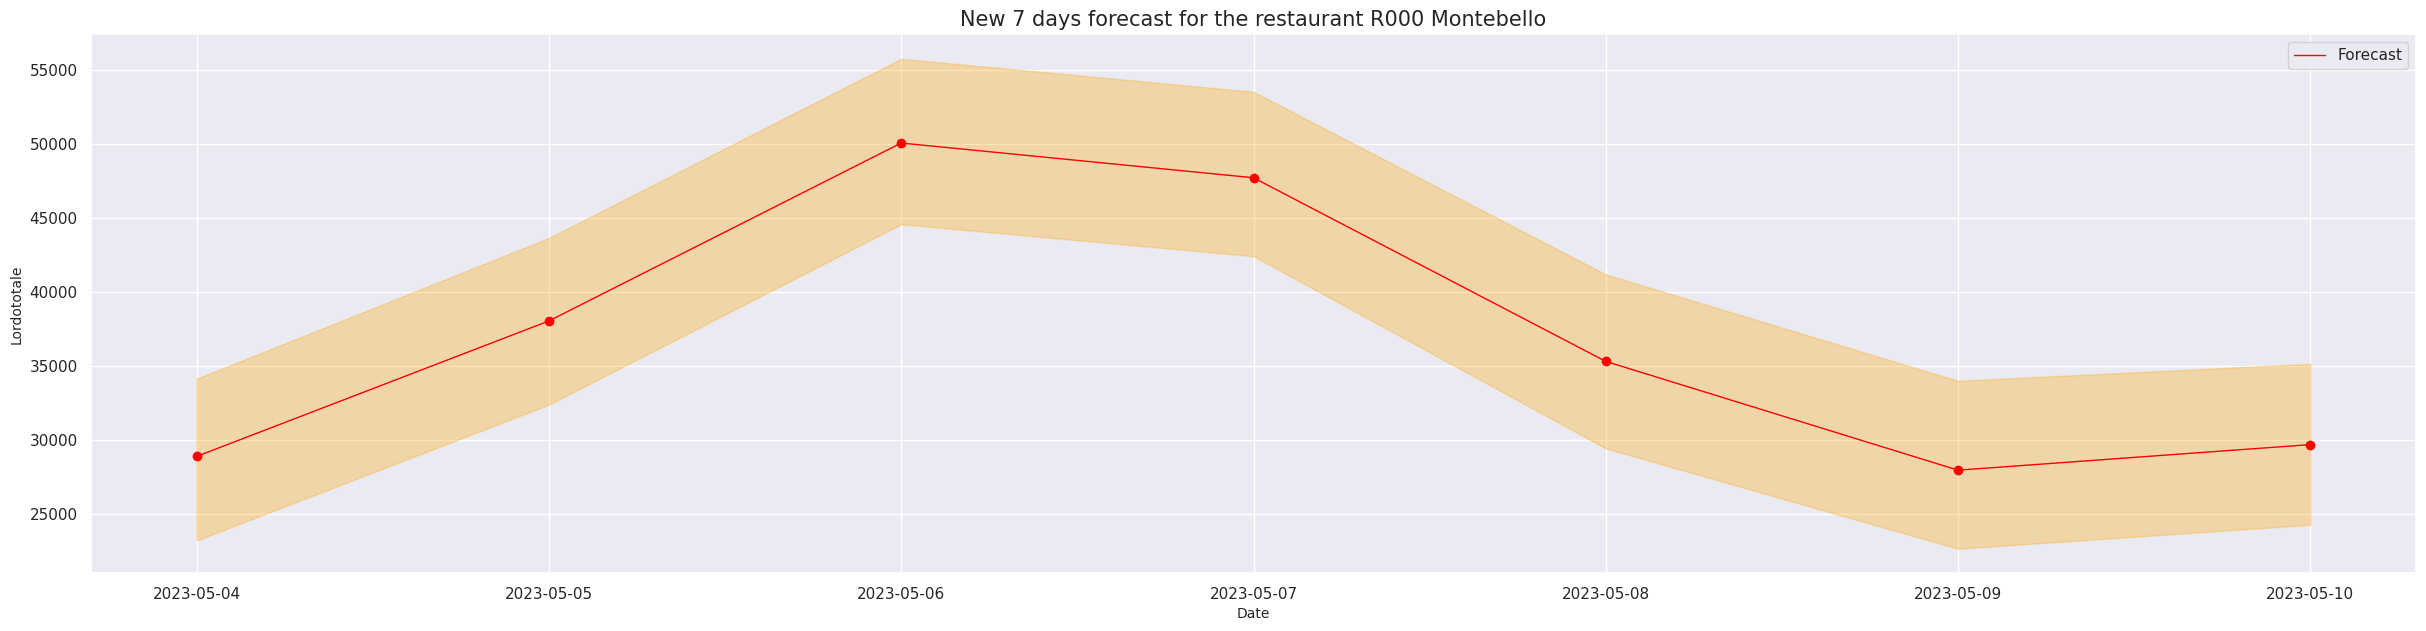

In [272]:
plot_future(forecast_m, 'R000 Montebello')

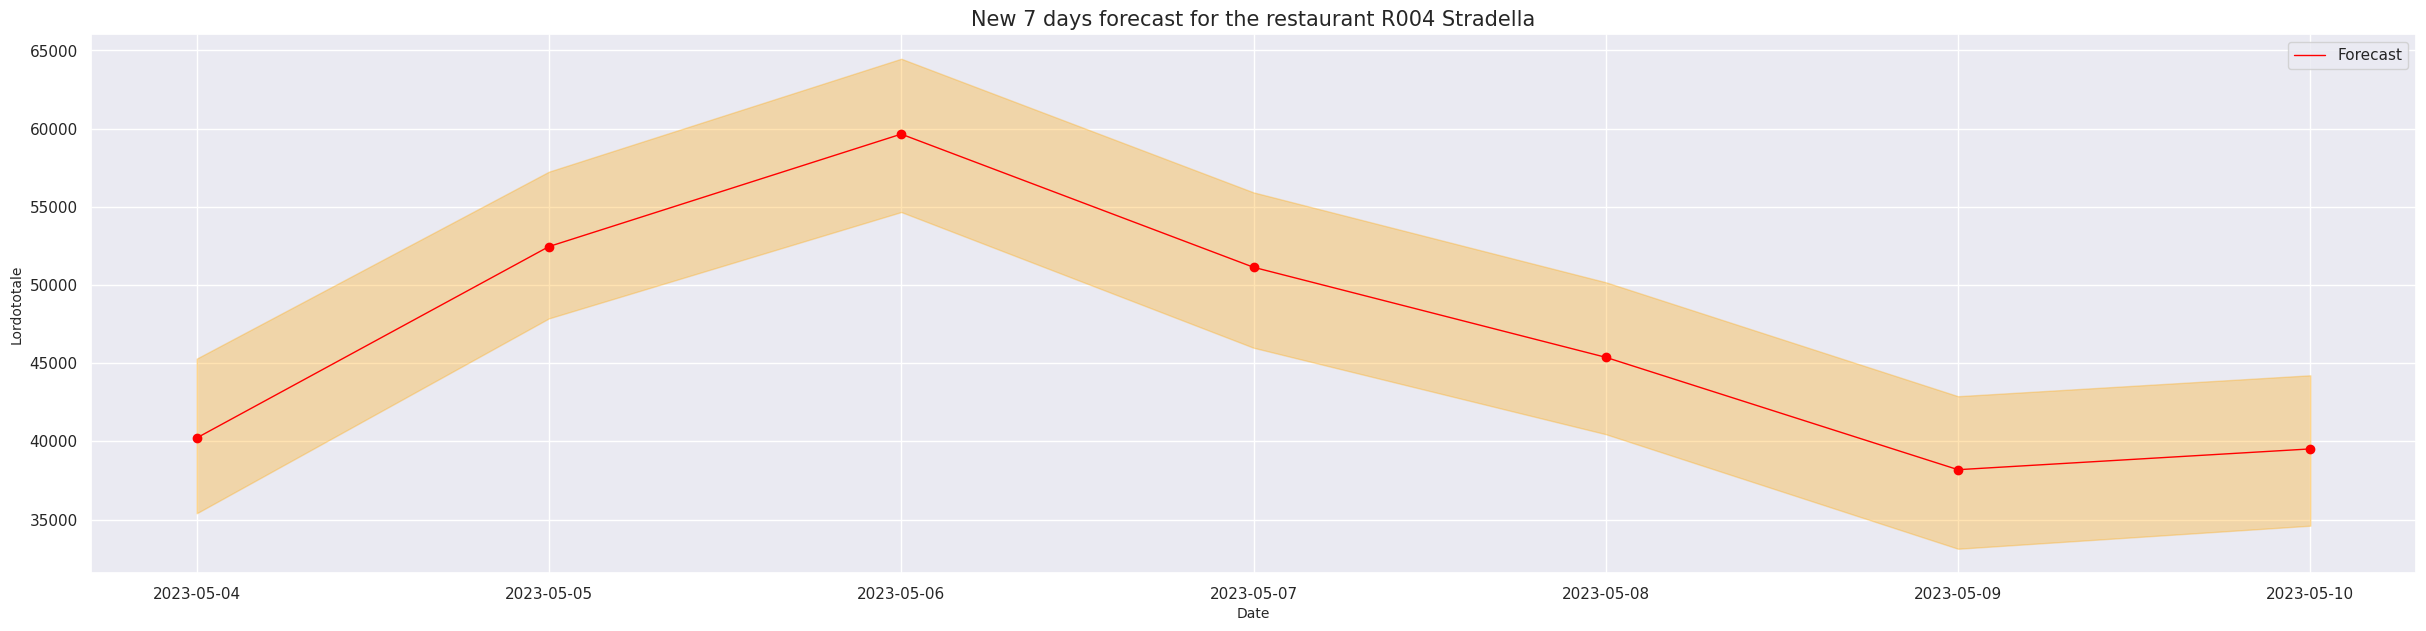

In [273]:
plot_future(forecast_s, 'R004 Stradella')

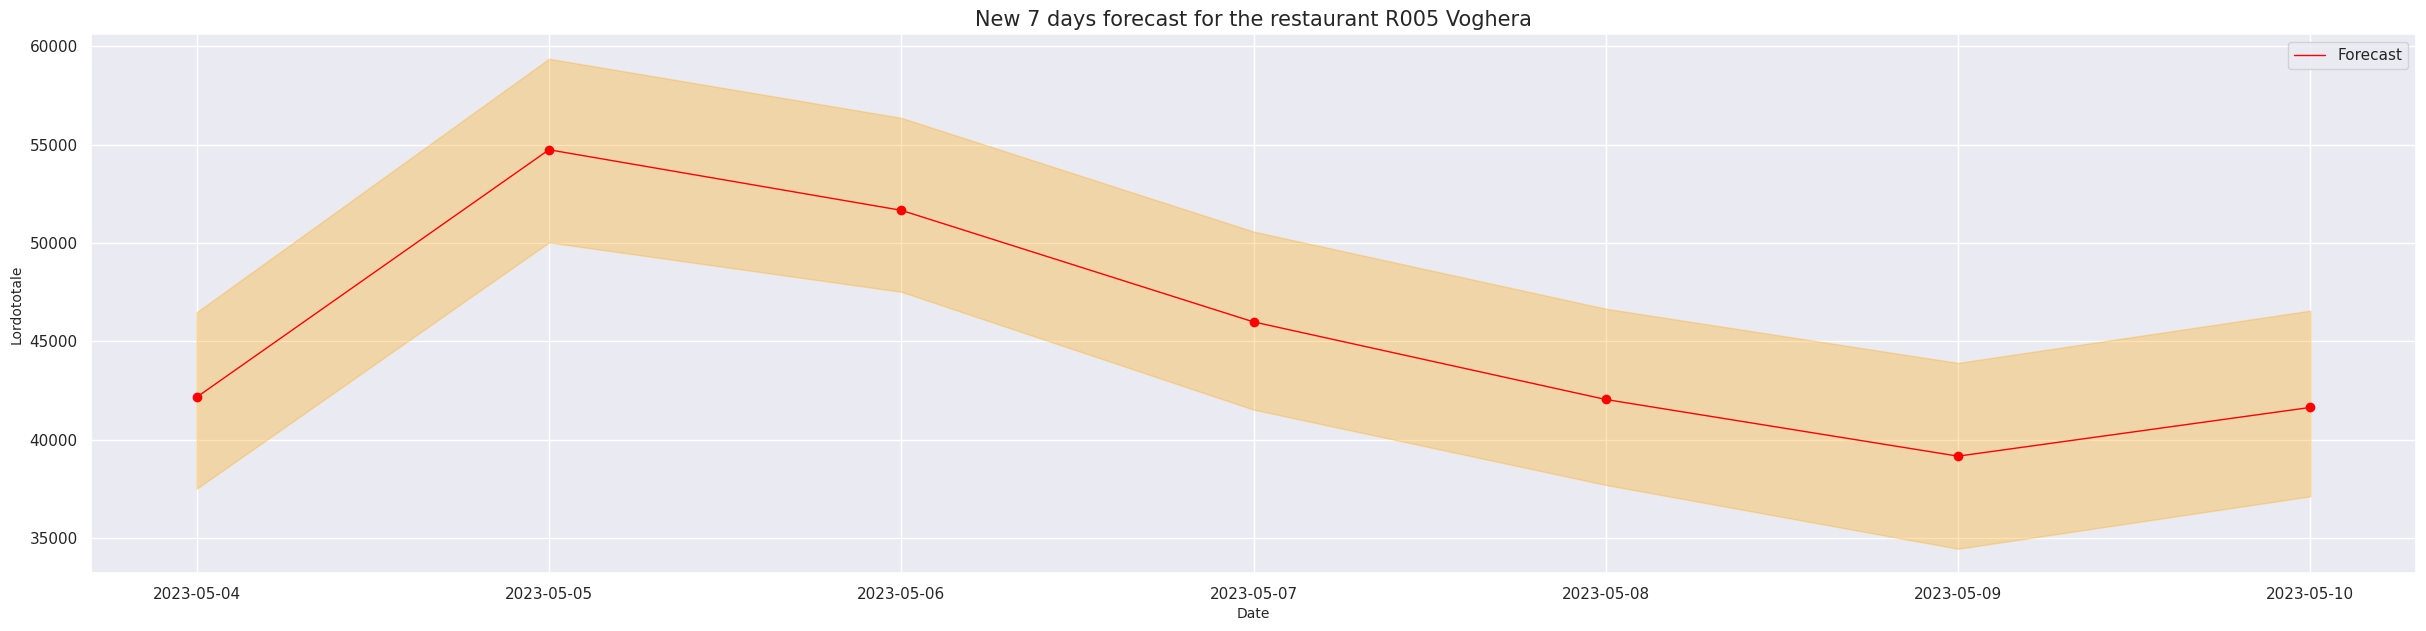

In [274]:
plot_future(forecast_v, 'R005 Voghera')

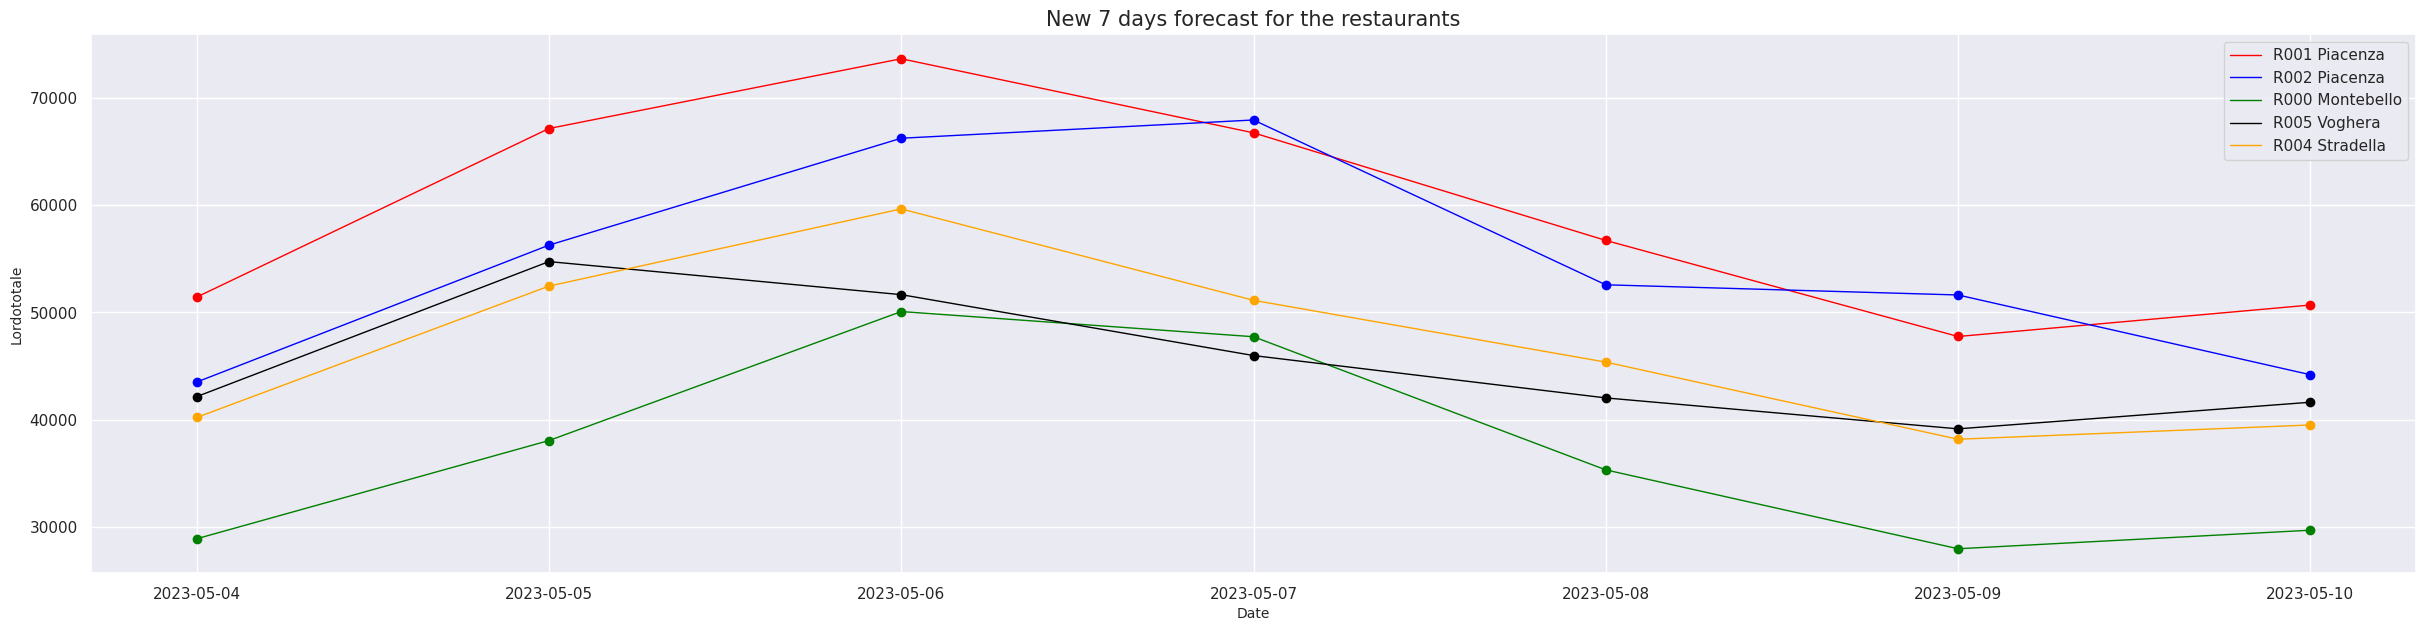

In [275]:
sns.set_style('darkgrid')
# sns.set(rc={'figure.figsize':(15,5)})

ax = sns.lineplot(data=forecast_p1, x ='ds', y = 'yhat', color = 'red', label= 'R001 Piacenza', lw=1)
ax = sns.lineplot(data=forecast_p2, x ='ds', y = 'yhat', color = 'blue', label= 'R002 Piacenza', lw=1)
ax = sns.lineplot(data=forecast_m, x ='ds', y = 'yhat', color = 'green', label= 'R000 Montebello', lw=1)
ax = sns.lineplot(data=forecast_v, x ='ds', y = 'yhat', color = 'black', label= 'R005 Voghera', lw=1)
ax = sns.lineplot(data=forecast_s, x ='ds', y = 'yhat', color = 'orange', label= 'R004 Stradella', lw=1)

ax.scatter(data=forecast_p1, x='ds', y='yhat', color='red')
ax.scatter(data=forecast_p2, x='ds', y='yhat', color='blue')
ax.scatter(data=forecast_m, x='ds', y='yhat', color='green')
ax.scatter(data=forecast_v, x='ds', y='yhat', color='black')
ax.scatter(data=forecast_s, x='ds', y='yhat', color='orange')


plt.title('New 7 days forecast for the restaurants', fontsize=15)
plt.ylabel('Lordototale', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.show()

In the Prophet model, the "yhat_lower" and "yhat_upper" values represent the uncertainty interval for the predicted values. These values define the lower and upper bounds of the interval within which the actual values are likely to fall.

When making predictions with the Prophet model, not only does it provide a point estimate for the predicted value ("yhat"), but it also provides an estimate of the uncertainty associated with that prediction. The "yhat_lower" and "yhat_upper" values capture this uncertainty by defining the lower and upper bounds, respectively, of a confidence interval.

The confidence interval, determined by the model's parameters and the historical data, represents the range within which the actual values are expected to occur with a certain level of confidence. By default, Prophet provides a **80% confidence interval**, meaning that the predicted values are expected to fall within the range defined by "yhat_lower" and "yhat_upper" 80% of the time.

In summary, the "yhat_lower" and "yhat_upper" values in the Prophet model provide information about the uncertainty or confidence interval associated with the predicted values, giving a range within which the actual values are likely to occur.